# Data Preprocessing

In [ ]:
customer_df = pd.read_csv('customer_df.csv')

In [ ]:
customer_df.shape

(110518, 15)

## Fonctions utilis√©es

In [ ]:
# Fonctions pour representation graphique

def correlation_graph_interactive(pca, x_y, features,labels=False):
    # Extraire x et y
    x, y = x_y

    # Cr√©er une figure
    fig =  go.Figure()

    # For each component:
    for i in range(0, pca.components_.shape[1]):
        # Cr√©er des annotations de fl√®ches pour les composants
        fig.add_trace(go.Scatter(
            x=[0, pca.components_[x, i]],
            y=[0, pca.components_[y, i]],
            mode='lines+markers+text',
            marker=dict(size=10),
            line=dict(width=2),
            # text=[features[i]]*2,
            # textposition='top center',
            name=f"{features[i]}",
            hovertext=f"{features[i]}: ({pca.components_[x, i]:.2f}, {pca.components_[y, i]:.2f})")
        )
      # Ajouter des annotations pour chaque √©tiquette afin d'√©viter les chevauchements
        if labels:
          fig.add_annotation(
            x=pca.components_[x, i] + (0.1 if pca.components_[x, i] >= 0 else -0.1),
            y=pca.components_[y, i] + (0.1 if pca.components_[y, i] >= 0 else -0.1),
            text=features[i],
            showarrow=False,
            font=dict(size=10),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black'
        )

    # Ajouter des lignes horizontales et verticales
    fig.add_shape(type="line", x0=-1, x1=1, y0=0, y1=0, line=dict(color="grey", dash="dash"))
    fig.add_shape(type="line", x0=0, x1=0, y0=-1, y1=1, line=dict(color="grey", dash="dash"))

    # Ajouter le cercle d'unit√© pour l'√©chelle
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = np.cos(theta)
    circle_y = np.sin(theta)
    fig.add_trace(go.Scatter(x=circle_x, y=circle_y, mode="lines", name="Unit Circle"))

    # D√©finir les titres des axes avec le pourcentage de variance expliqu√©e
    fig.update_xaxes(title_text=f'PC{x+1} ({round(100*pca.explained_variance_ratio_[x], 1)}%)')
    fig.update_yaxes(title_text=f'PC{y+1} ({round(100*pca.explained_variance_ratio_[y], 1)}%)')

    # D√©finir le titre
    fig.update_layout(title_text=f"Cercle des corr√©lations  (PC{x+1} et PC{y+1})", showlegend=False)

    # # Si une representation sous forme d'un cercle est voulu
    # fig.update_layout(
    #     title_text=f"Correlation Circle (PC{x+1} and PC{y+1})",
    #     showlegend=True,
    #     xaxis=dict(scaleanchor="y", scaleratio=1)  # Ensure the aspect ratio is equal
    # )

    fig.show()

def percentage_clusters_graph(df, algo):
    # Calculer le pourcentage de clients dans chaque groupe
    cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index(name='percentage')
    cluster_percentage.sort_values(by='cluster', inplace=True)

    # Cr√©er un diagramme √† barres horizontales
    plt.figure(figsize=(10, 4))
    sns.barplot(x='percentage', y='cluster', data=cluster_percentage, orient='h')

    # Ajout de pourcentages sur les barres
    for index, value in enumerate(cluster_percentage['percentage']):
        plt.text(value+0.5, index, f'{value:.2f}%')

    plt.title(str(algo)+ ' : R√©partition des clients entre les Clusters', fontsize=14)
    plt.xticks(ticks=np.arange(0, 50, 5))
    plt.xlabel('Percentage (%)')

    plt.show()

def percentage_clusters_graphs(algo,*dfs):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    num_datasets = len(dfs)

    # Create subplots
    fig, axes = plt.subplots(1, num_datasets, figsize=(10 * num_datasets, 6))

    if num_datasets == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot

    for i, df in enumerate(dfs):
        # Calculate the percentage of customers in each cluster
        cluster_percentage = (df['cluster'].value_counts(normalize=True) * 100).reset_index()
        cluster_percentage.columns = ['cluster', 'percentage']
        cluster_percentage.sort_values(by='cluster', inplace=True)

        # Create a horizontal bar plot
        sns.barplot(x='percentage', y='cluster', data=cluster_percentage, orient='h', ax=axes[i])

        # Add percentage labels on the bars
        for index, value in enumerate(cluster_percentage['percentage']):
            axes[i].text(value + 0.5, index, f'{value:.2f}%')

        axes[i].set_title(f'{methods[i]}', fontsize=14)
        axes[i].set_xticks(np.arange(0, 101, 10))
        axes[i].set_xlabel('Percentage (%)')

    fig.suptitle(algo + ': R√©partition des clients entre les Clusters',fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
# Fonction pour estimation du nombre optimal de groupe pour K-means

def plot_elbow_method(*datasets):
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(10 * n_datasets, 5))

    if n_datasets == 1:
        axes = [axes]

    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']

    for i, data in enumerate(datasets):
        wcss = []
        k_values = range(1, 11)  # You can increase the range based on your requirement
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
            kmeans.fit(data)
            wcss.append(kmeans.inertia_)

        axes[i].plot(k_values, wcss, 'bo-')
        axes[i].set_xlabel('Number of Clusters')
        axes[i].set_ylabel('WCSS')
        axes[i].set_title(f'Elbow Method for {methods[i]}')

        # Annotate the WCSS values on the plot
        # for j, txt in enumerate(wcss):
        #     axes[i].annotate(f'{txt:.2f}', (k_values[j], wcss[j]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()


def plot_silhouette_analysis(k_start, k_end, *datasets):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)
    fig, axes = plt.subplots(1, n_datasets, figsize=(10 * n_datasets, 5))

    if n_datasets == 1:
        axes = [axes]

    for i, data in enumerate(datasets):
        silhouette_avg = []
        k_values = range(k_start, k_end + 1)
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=100)
            kmeans.fit(data)
            cluster_labels = kmeans.labels_
            silhouette_avg.append(silhouette_score(data, cluster_labels))

        axes[i].plot(k_values, silhouette_avg, 'bo-')
        axes[i].set_xlabel('Number of Clusters')
        axes[i].set_ylabel('Silhouette Score')
        axes[i].set_title(f'Silhouette Analysis for {methods[i]}')

        # Annotate the Silhouette scores on the plot
        # for j, txt in enumerate(silhouette_avg):
        #     axes[i].annotate(f'{txt:.2f}', (k_values[j], silhouette_avg[j]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()


In [ ]:
# Returns the set of X configurations with shorter distance
def SelBest(arr: list, X: int) -> list:
    dx = np.argsort(arr)[:X]
    return arr[dx]

def plot_gmm_silhouette(*datasets, n_clusters_range=np.arange(2, 7), iterations=10):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)

    fig, axs = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 6), sharey=True)
    if n_datasets == 1:
        axs = [axs]

    for idx, data in enumerate(datasets):
        sils = []
        sils_err = []

        for n in n_clusters_range:
            tmp_sil = []
            for _ in range(iterations):
                gmm = GMM(n, n_init=2, random_state=42).fit(data)
                labels = gmm.predict(data)
                sil = silhouette_score(data, labels, metric='euclidean')
                tmp_sil.append(sil)

            val = np.mean(SelBest(np.array(tmp_sil), int(iterations / 5)))
            err = np.std(tmp_sil)
            sils.append(val)
            sils_err.append(err)

        axs[idx].errorbar(n_clusters_range, sils, yerr=sils_err, fmt='-o')
        axs[idx].set_title(f"{methods[idx]}", fontsize=14)
        axs[idx].set_xticks(n_clusters_range)
        axs[idx].set_xlabel("Number of Clusters")
        axs[idx].set_ylabel("Mean Silhouette Score")

    plt.suptitle("Silhouette Scores for GMM Clustering", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def plot_gmm_js_divergence(*datasets, n_clusters=np.arange(2, 7), iterations=10):
    methods = ['Original Data', 'PCA transformed Data', 'Kernel transformed Data']
    n_datasets = len(datasets)

    fig, axs = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 6), sharey=True)
    if n_datasets == 1:
        axs = [axs]

    for idx, data in enumerate(datasets):
        results = []
        res_sigs = []

        for n in n_clusters:
            dist = []
            for iteration in range(iterations):
                # Split the data into two parts
                train, test = train_test_split(data.values, test_size=0.5, random_state=42)

                gmm_train = GMM(n, n_init=2, random_state=42).fit(train)
                gmm_test = GMM(n, n_init=2, random_state=42).fit(test)

                # Calculate the JS divergence
                dist.append(gmm_js(gmm_train, gmm_test))

            # Select the best series and calculate the mean and standard deviation
            selec = SelBest(np.array(dist), int(iterations / 5))
            result = np.mean(selec)
            res_sig = np.std(selec)
            results.append(result)
            res_sigs.append(res_sig)

        axs[idx].errorbar(n_clusters, results, yerr=res_sigs)
        axs[idx].set_title(f"{methods[idx]}", fontsize=14)
        axs[idx].set_xticks(n_clusters)
        axs[idx].set_xlabel("Number of Clusters")
        axs[idx].set_ylabel("JS Divergence")

    plt.suptitle("Optimal Number of Clusters using JS Divergence", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




In [ ]:
def evaluate_metrics(df,transformation, name_algo,df_scores=pd.DataFrame()):
    # S√©parer les caract√©ristiques et les √©tiquettes des clusters
    X = df.drop('cluster', axis=1)
    clusters = df['cluster']

    # Calculer les m√©triques
    sil_score = silhouette_score(X, clusters)
    calinski_score = calinski_harabasz_score(X, clusters)
    davies_score = davies_bouldin_score(X, clusters)

    # Cr√©er un dataframe pour afficher les m√©triques

    results = pd.DataFrame({
        "Transformation" : [transformation],
        "Algorithms": [name_algo],
        "Number of Clusters" : [len(set(clusters))],
        "Silhouette Score": [sil_score],
        "Calinski Harabasz Score": [calinski_score],
        "Davies Bouldin Score": [davies_score]
    })
    if df_scores.empty:
        df_scores = results.copy()
    else:
        df_scores = pd.concat([df_scores, results], ignore_index=True)

    return df_scores

## D√©tection et traitement des valeurs aberrantes

Dans cette section, je vais identifier et traiter les valeurs aberrantes dans notre ensemble de donn√©es. Ces points peuvent potentiellement fausser les r√©sultats de notre analyse, en particulier dans le cas du regroupement par k-means, o√π ils peuvent influencer de mani√®re significative la position des centro√Ødes.

√âtant donn√© la nature multidimensionnelle des donn√©es, il serait prudent d'utiliser des algorithmes capables de d√©tecter les valeurs aberrantes dans des espaces multidimensionnels. Je vais utiliser l'algorithme **Isolation Forest ** pour cette t√¢che.

In [ ]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_df['outlier_scores'] = model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

customer_df['is_outlier'] = [1 if x == -1 else 0 for x in customer_df['outlier_scores']]

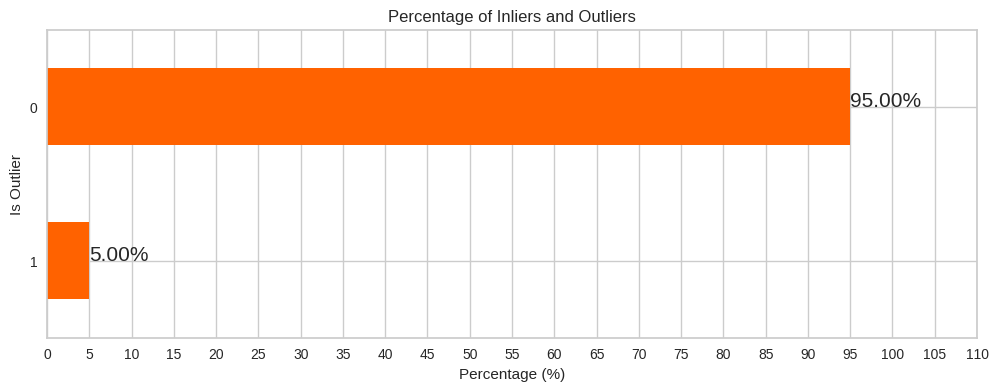

In [ ]:
# Calculer le pourcentage de valeurs aberrantes et non aberrantes
outlier_percentage = customer_df['is_outlier'].value_counts(normalize=True) * 100

# Repr√©sentation graphique du pourcentage de valeurs aberrantes et non aberrantes
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Ajout des √©tiquettes de pourcentage sur les barres
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

> Pour √©viter que ces valeurs aberrantes n'affectent de mani√®re significative la qualit√© des grappes, je les supprimerai de notre ensemble de donn√©es principal afin de le pr√©parer √† l'analyse par grappes.

In [ ]:
# Supprimer les valeurs aberrantes de l'ensemble de donn√©es principal
customer_df = customer_df[customer_df['is_outlier'] == 0]

# Supprimer les colonnes 'outlier_scores' et 'is_outlier'
customer_df = customer_df.drop(columns=['outlier_scores', 'is_outlier'])

# R√©initialiser l'index des donn√©es nettoy√©es
customer_df.reset_index(drop=True, inplace=True)

In [ ]:
customer_df.shape

(104992, 15)

## Analyse de corr√©lation

Avant de proc√©der au regroupement KMeans, il est essentiel de v√©rifier la corr√©lation entre les caract√©ristiques de notre ensemble de donn√©es. La pr√©sence d'une multicolin√©arit√©, o√π les caract√©ristiques sont fortement corr√©l√©es, peut potentiellement affecter le processus de clustering en ne permettant pas au mod√®le d'apprendre les mod√®les sous-jacents r√©els dans les donn√©es.


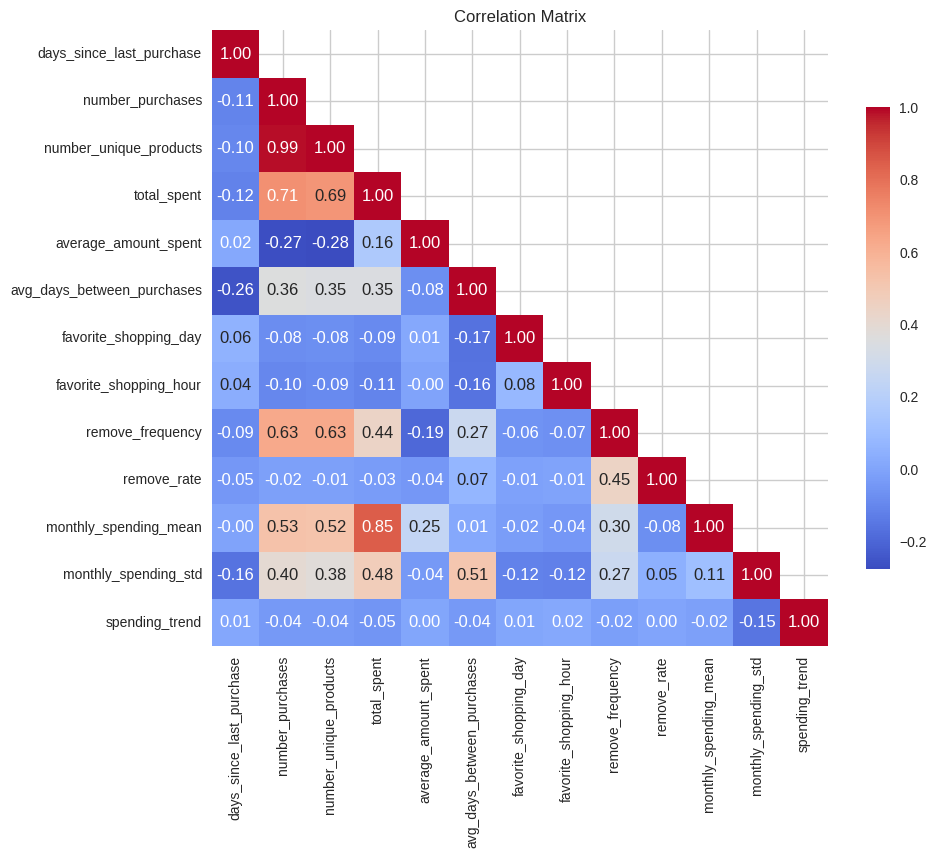

In [ ]:
# Calculer la matrice de corr√©lation en excluant la colonne "user_id".
corr_matrix = customer_df.drop(['user_id','number_events'], axis=1).corr()

# Cr√©er un masque pour le triangle sup√©rieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Tracer la carte thermique
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .75})

plt.title('Correlation Matrix')
plt.show()

En examinant la carte thermique, nous pouvons voir que certaines paires de variables ont des corr√©lations √©lev√©es, ce qui indiquent que ces variables √©voluent √©troitement ensemble, par exemple :

'number_unique_products' et 'number_purchases'

'total_spent' et 'number_purchases'

'number_purchases' et 'remove_frequency'

'total_spent' et 'monthly_spending_mean'

> Avant de passer aux √©tapes suivantes, nous pouvons utiliser des techniques de r√©duction de la dimensionnalit√© telles que l'ACP. Ces techniques permettent de neutraliser l'effet de la multicolin√©arit√© en transformant les caract√©ristiques corr√©l√©es en un nouvel ensemble de variables non corr√©l√©es, en pr√©servant la majeure partie de la variance des donn√©es d'origine.


## Mise √† l'√©chelle des caract√©ristiques

Avant de proc√©der au clustering et √† la r√©duction de la dimensionnalit√©, il est imp√©ratif de mettre nos caract√©ristiques √† l'√©chelle. Cette √©tape rev√™t une importance significative, en particulier dans le contexte des algorithmes bas√©s sur la distance tels que les K-means et les m√©thodes de r√©duction de la dimensionnalit√© qui d√©pend de la variation des donn√©es telles que l'ACP.

Pour garantir une influence √©quilibr√©e sur le mod√®le et r√©v√©ler les v√©ritables tendances des donn√©es, je vais normaliser nos donn√©es, c'est-√†-dire transformer les caract√©ristiques pour qu'elles aient une moyenne de 0 et un √©cart-type de 1.

In [ ]:
customer_df_scaled = customer_df.copy()

# Colonnes qui ont besoin d'√™tre mis √† l'√©chelle
columns_to_scale = customer_df.columns.difference(['user_id', 'favorite_shopping_day'])

# Appliquer StandardScaler aux colonnes s√©lectionn√©es
scaler = StandardScaler()
customer_df_scaled[columns_to_scale] = scaler.fit_transform(customer_df_scaled[columns_to_scale])

customer_df_scaled.head()

user_id  days_since_last_purchase  number_events  number_purchases  \
0   9794320                  0.568599       0.769919         -0.534716   
1  10079204                  1.003861      -0.728608         -0.752620   
2  12055855                 -0.004114      -0.541293         -0.534716   
3  12936739                 -0.645552      -0.648330         -0.752620   
4  15400971                  0.156246      -0.621571         -0.643668   

   number_unique_products  total_spent  average_amount_spent  \
0               -0.531169    -0.755406             -0.450419   
1               -0.760666    -0.434777              0.512151   
2               -0.531169    -0.661147             -0.355003   
3               -0.760666    -0.335146              0.713861   
4               -0.645917    -0.193024              0.413109   

   avg_days_between_purchases  favorite_shopping_day  favorite_shopping_hour  \
0                   -0.347604                      0               -1.458966   
1                   -0.347604                      2               -0.487167   
2                   -0.347604                      4               -0.098448   
3                   -0.347604                      4               -1.070246   
4                   -0.347604                      4               -0.098448   

   remove_frequency  remove_rate  monthly_spending_mean  monthly_spending_std  \
0          1.089150     1.904172              -0.757062             -0.260749   
1         -0.657128    -1.006373              -0.349044             -0.260749   
2         -0.495436    -0.090468              -0.637112             -0.260749   
3         -0.560113     0.432907              -0.222257             -0.260749   
4         -0.560113    -0.166793              -0.041399             -0.260749   

   spending_trend  
0        0.026758  
1        0.026758  
2        0.026758  
3        0.026758  
4        0.026758

In [ ]:
idx = ["mean", "std"]

pd.DataFrame(customer_df_scaled).describe().round(2).loc[idx, :]

user_id  days_since_last_purchase  number_events  number_purchases  \
mean  5.304387e+08                       0.0           -0.0              -0.0   
std   8.661082e+07                       1.0            1.0               1.0   

      number_unique_products  total_spent  average_amount_spent  \
mean                    -0.0         -0.0                   0.0   
std                      1.0          1.0                   1.0   

      avg_days_between_purchases  favorite_shopping_day  \
mean                        -0.0                   2.70   
std                          1.0                   1.95   

      favorite_shopping_hour  remove_frequency  remove_rate  \
mean                     0.0               0.0         -0.0   
std                      1.0               1.0          1.0   

      monthly_spending_mean  monthly_spending_std  spending_trend  
mean                   -0.0                   0.0             0.0  
std                     1.0                   1.0             1.0

## R√©duction de la dimensionnalit√©

Dans cette √©tape, nous envisageons d'appliquer des techniques de r√©duction de la dimensionnalit√© pour simplifier nos donn√©es tout en conservant les informations essentielles. Parmi les diff√©rentes m√©thodes telles que PCA, KernelPCA, ICA, ISOMAP, TSNE et UMAP, je choisis PCA (Analyse en Composantes Principales) et KernelPCA. Voici pourquoi :

**PCA :** excellent point de d√©part car elle permet de capturer les relations lin√©aires dans les donn√©es, ce qui est particuli√®rement pertinent compte tenu de la multicolin√©arit√© que nous avons identifi√©e dans notre ensemble de donn√©es.

Dans le cas o√π les premi√®res composantes du PCA ne capturent pas une part significative de la variance, ce qui indique une perte d'informations essentielles, nous pourrions envisager d'explorer d'autres m√©thodes non lin√©aires.

**KernelPCA :** Cette m√©thode peut potentiellement fournir une approche plus nuanc√©e de la r√©duction de la dimensionnalit√©, en capturant des mod√®les complexes que l'ACP pourrait manquer, bien qu'au prix d'un temps de calcul et d'une complexit√© accrus.





In [ ]:
# user_id comme colonne index
customer_df_scaled.set_index('user_id', inplace=True)
customer_df_scaled.drop('number_events', axis=1, inplace=True)

***PCA :***

In [ ]:
# Appliquer l'ACP
pca = PCA().fit(customer_df_scaled.values)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

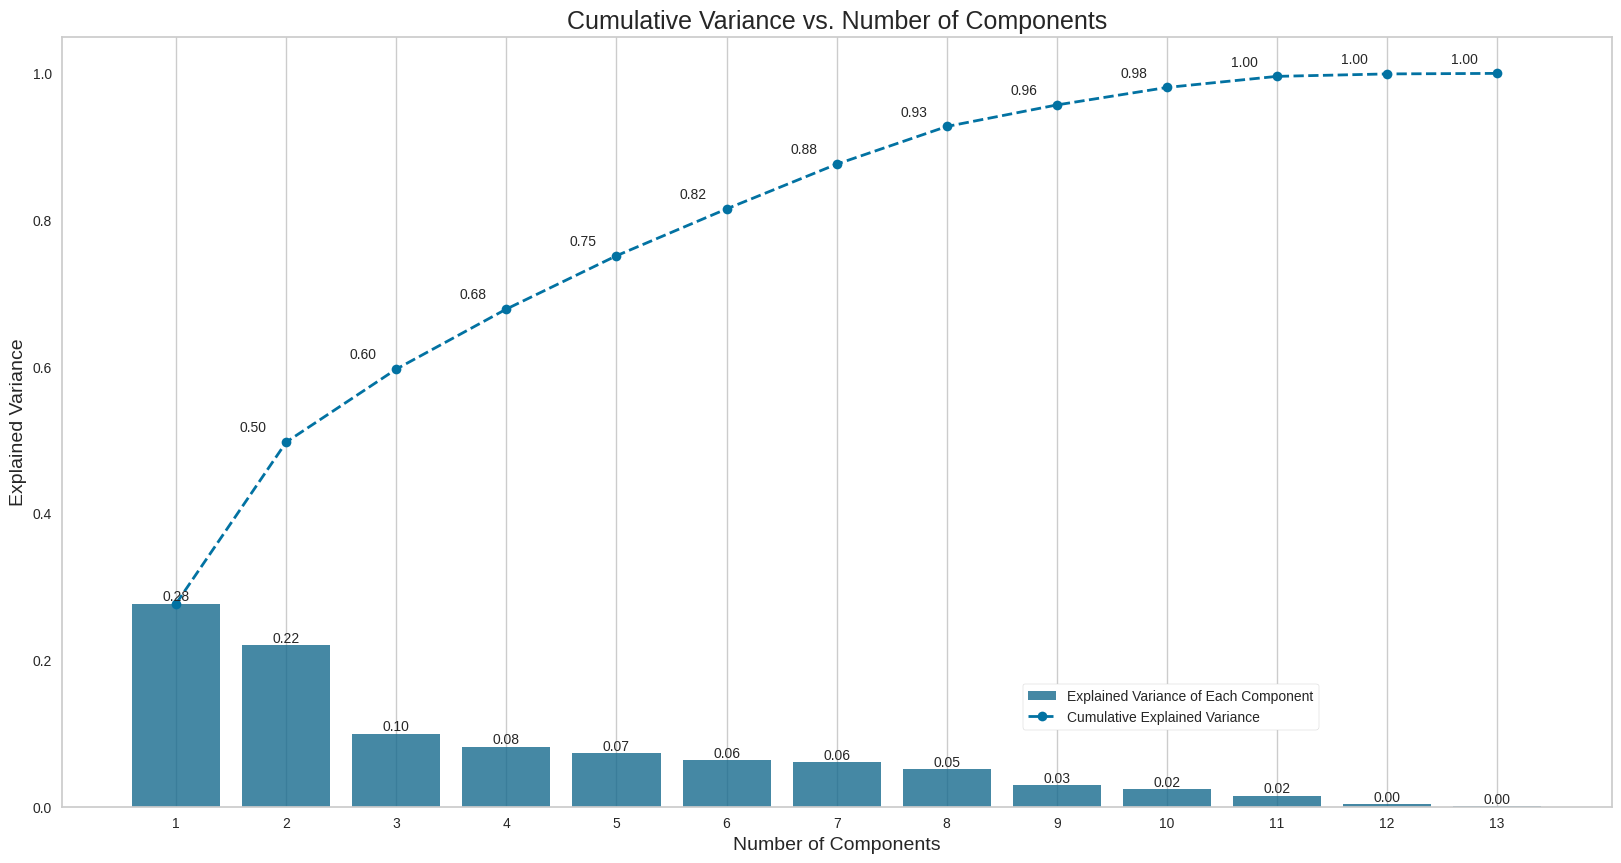

In [ ]:
plt.figure(figsize=(20, 10))

# Diagramme √† barres de la variance expliqu√©e de chaque composante
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      # color='#fcc36d',
                      alpha=0.8)

# Graphique lin√©aire de la variance expliqu√©e cumulative
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--',
                    #  color='#ff6200',
                     linewidth=2)

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Personnaliser les ticks et la l√©gende
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
          #  edgecolor='#ff6200'
           )

# Afficher les valeurs de variance pour les deux graphiques sur les courbes
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

On a la variance de chaque nouvelle composante, et en ligne la variance cumul√©e. On voit ici que pr√®s de 82% de la variance est comprise dans les 6 premi√®res composantes, et 88% dans les 7 premi√®res.

Pour choisir le nombre optimal de composantes, nous recherchons g√©n√©ralement un point o√π l'ajout d'une autre composante n'augmente pas de mani√®re significative la variance expliqu√©e cumul√©e, souvent appel√© le "point de coude" de la courbe.

Le graphique montre que l'augmentation de la variance cumul√©e commence √† ralentir apr√®s la septi√®me composante (qui capture environ 88 % de la variance totale). Par cons√©quent, le maintien des sept premiers √©l√©ments pourrait √™tre un choix √©quilibr√©.

In [ ]:
n_components = 7
pca = PCA(n_components=n_components)

# Ajustement et transformation des donn√©es originales dans le nouveau cadre de donn√©es de l'ACP
customer_df_pca = pca.fit_transform(customer_df_scaled)

# Cr√©ation d'un nouveau dataframe √† partir du dataframe de l'ACP, avec des colonnes intitul√©es PC1, PC2, etc.
customer_df_pca = pd.DataFrame(customer_df_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Aajout de l'index user_id au nouveau dataframe PCA
customer_df_pca.index = customer_df_scaled.index

customer_df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7
user_id                                                                       
9794320  -1.220829 -2.541808 -1.507854 -1.039809  1.515307 -0.353740 -1.665926
10079204  0.735216 -1.507488  0.905215  0.239367 -0.510380 -0.208475 -0.825984
12055855  1.798332  0.160111 -0.466678  0.121503 -0.313818  0.059372 -0.167412
12936739  1.660055  0.205826  0.036527  0.948287  0.848472  0.390216 -0.738220
15400971  1.660360  0.314040  0.459204  0.363693  0.161962  0.022868 -0.186477

Int√©ressons nous maintenant √† nos fameuses composantes. La formule de ce calcul nous est donn√©e par l'attribut `components_`

In [ ]:
# Cr√©ez le DataFrame de la composante ACP
pcs = pd.DataFrame(pca.components_)
pcs.columns = customer_df_scaled.columns
pcs.index = [f"PC{i}" for i in range(1, n_components+1)]
pcs.T

PC1       PC2       PC3       PC4       PC5  \
days_since_last_purchase    0.091535 -0.033721  0.196608 -0.389982 -0.092441   
number_purchases           -0.347286  0.305301 -0.022782 -0.168636 -0.206200   
number_unique_products     -0.342538  0.303979 -0.025563 -0.184903 -0.209640   
total_spent                -0.329002  0.282082  0.316095  0.089625  0.096685   
average_amount_spent        0.052069 -0.040800  0.504907  0.330186  0.507691   
avg_days_between_purchases -0.239461  0.088796 -0.286524  0.441313 -0.018979   
favorite_shopping_day       0.628435  0.768287 -0.062776  0.094737 -0.002266   
favorite_shopping_hour      0.088072 -0.012298  0.051785 -0.262513 -0.019308   
remove_frequency           -0.263776  0.232802 -0.262730 -0.289924  0.302384   
remove_rate                -0.036799  0.028378 -0.390269 -0.215590  0.722921   
monthly_spending_mean      -0.227700  0.241717  0.514278 -0.110195  0.140323   
monthly_spending_std       -0.242562  0.139886 -0.170846  0.436764 -0.022853   
spending_trend              0.032920 -0.026802  0.039992 -0.249290  0.053735   

                                 PC6       PC7  
days_since_last_purchase   -0.378313 -0.426815  
number_purchases            0.016656  0.003322  
number_unique_products      0.013391  0.005504  
total_spent                 0.009228  0.030113  
average_amount_spent        0.014119  0.028612  
avg_days_between_purchases  0.130160  0.032417  
favorite_shopping_day       0.022988 -0.024411  
favorite_shopping_hour     -0.129481  0.898391  
remove_frequency           -0.047618 -0.032143  
remove_rate                -0.101612 -0.035608  
monthly_spending_mean       0.002541  0.015950  
monthly_spending_std       -0.125241  0.040460  
spending_trend              0.890852 -0.055830

<Axes: >

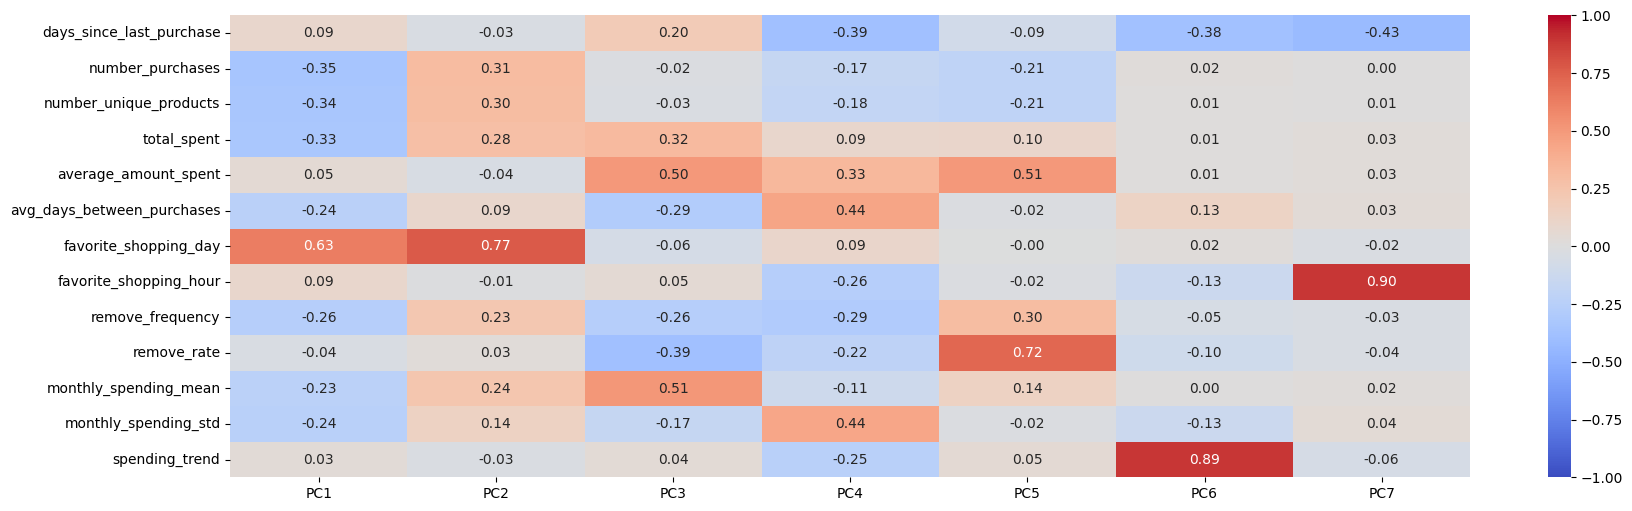

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [ ]:
# Graphe des corr√©lations pour les deux premi√®res composantes principales
x_y = (0,1)
correlation_graph_interactive(pca, x_y, customer_df_scaled.columns)

D'apr√®s la heatmap et le graph de correlation, les variables les plus corr√©l√©es positivement √† PC1 sont :
'number_purchases' ;
'number_unique_products' ;
'total_spent';
 mais on a aussi la variable 'favorite_shopping_day' qui est corr√©l√©e n√©gativement √† PC1.
 Quant √† PC2, la variable la plus corr√©l√©es est 'favorite_shopping_day'.

In [ ]:
x_y = (2,3)
correlation_graph_interactive(pca, x_y, customer_df_scaled.columns, labels=True)

D'apr√®s la heatmap et le graph de correlation, les variables les plus corr√©l√©es positivement √† PC3 sont :
'remove_rate' ;
et pour les variables corr√©l√©es n√©gativement on a 'monthly_spending_mean'; 'average_amount_spent'.
 Quant √† PC4, la variable la plus corr√©l√©e positivement est
'days_since_last_purchase' and n√©gativement on a 'avg_days_between_purcahses'; 'monthly_spending_std'; 'average_amout_spent'.

***KernelPCA :***

L'ACP √† noyau implique le calcul d'une matrice √† noyau, qui peut n√©cessiter une grande quantit√© de m√©moire. La matrice du noyau a une taille de ùëÅ√óùëÅ o√π ùëÅ est le nombre d'√©chantillons. Dans notre cas, la matrice du noyau aurait la taille suivante
(104 992√ó104 992) √©l√©ments.
Le calcul des valeurs propres et des vecteurs propres pour une matrice de noyau aussi grande est tr√®s exigeant et a provoqu√© un plantage en raison du d√©passement des capacit√©s de traitement de ma machine.

Je vais donc utiliser deux strat√©gies pour traiter notre ensemble de donn√©es :
1. Utiliser un petit sous-ensemble de donn√©es pour d√©terminer le nombre optimal de composants √† l'aide de KernelPCA
2. Utiliser une m√©thode de noyau approximatif :

    Une fois que j'ai d√©termin√© le nombre optimal de composantes √† l'aide de KernelPCA, on va transformer l'ensemble de notre jeu de donn√©es en utilisant la m√©thode de noyau approximatif ad√©quate pour en r√©duire les dimensions. Le choix de cette m√©thode d√©pend du kernel selectionn√© comme meilleur param√®tre lors de la GridSearch.
    
    On va ensuite utiliser cet ensemble de donn√©es transform√© pour d'autres analyses, telles que le regroupement √† l'aide de KMeans.

> ***RBFSampler*** permet d'effectuer des transformations non lin√©aires similaires √† celles de KernelPCA. Il approxime le mappage des caract√©ristiques d'un noyau RBF (Radial Basis Function) √† l'aide de caract√©ristiques al√©atoires de Fourier, ce qui permet d'appliquer des algorithmes lin√©aires √† des donn√©es qui sont mapp√©es dans un espace de plus grande dimension, de mani√®re similaire √† l'effet de KernelPCA.

In [ ]:
# 1.
# J'utiliserai un sous-ensemble al√©atoire plus petit de nos donn√©es pour effectuer l'ACP √† noyau.
subset_size = 1000
subset_df = customer_df_scaled.sample(n=subset_size, random_state=42)

# Define a range of parameters
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.01, 0.1, 1, 10],
    'degree': [2, 3, 4]
}

# Scoreur personnalis√© pour utiliser la variance expliqu√©e
def explained_variance_scorer(estimator, X):
    transformed = estimator.fit_transform(X)
    explained_variance = np.var(transformed, axis=0).sum() / np.var(X, axis=0).sum()
    return explained_variance

# Initialiser KernelPCA
kpca = KernelPCA(fit_inverse_transform=True, random_state=42)

# Recherche en grille avec validation crois√©e
grid_search = GridSearchCV(kpca, param_grid, scoring=explained_variance_scorer, cv=3, verbose=1)
grid_search.fit(subset_df)

best_params = grid_search.best_params_


In [ ]:
# Best parameters
print("Best parameters:", best_params)

Best parameters: {'degree': 4, 'gamma': 10, 'kernel': 'poly'}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_kernel_pca.py:415: LinAlgWarning: Ill-conditioned matrix (rcond=2.64138e-24): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, assume_a="pos", overwrite_a=True)


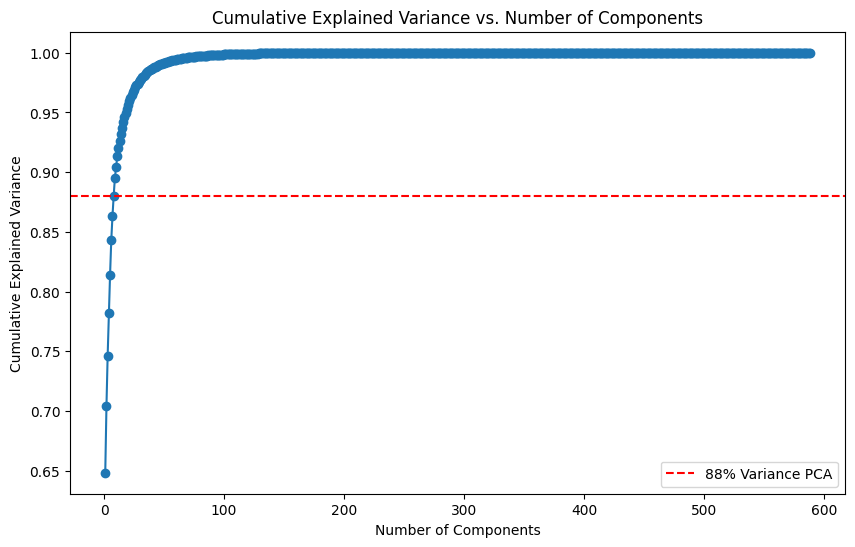

In [ ]:
# Appliquer KernelPCA
kernel_pca = KernelPCA(kernel=best_params['kernel'],
                 gamma=best_params.get('gamma', None),
                 degree=best_params.get('degree', None),
                 fit_inverse_transform=True,
                 random_state=42)
subset_kpca = kernel_pca.fit(subset_df)

# Valeurs propres
eigenvalues = kernel_pca.eigenvalues_

# Variance expliqu√©e
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Tracer la variance expliqu√©e cumulative
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.axhline(y=0.88, color='r', linestyle='--', label='88% Variance PCA')
plt.legend()
plt.show()


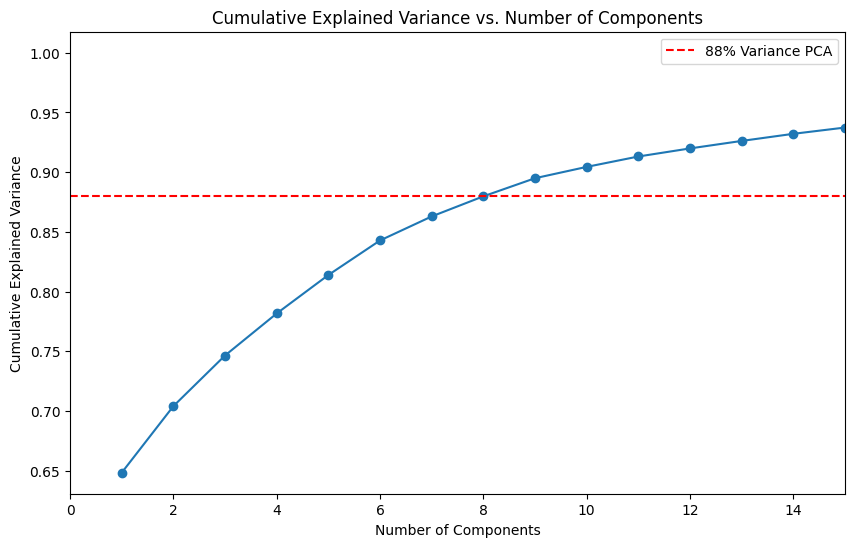

In [ ]:
# ZOOM IN
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlim(0, 15)
plt.axhline(y=0.88, color='r', linestyle='--', label='88% Variance PCA')
plt.legend()
plt.show()

On a la variance de chaque nouvelle composante, la variance cumul√©e. On voit ici que 88% de la variance est atteinte dans les 8 premi√®res composantes.
On se contentera de garder le nombre de composantes qui nous permet d'atteindre 88% comme pour le PCA. Par cons√©quent, le maintien des huit premiers √©l√©ments pourrait √™tre un choix √©quilibr√©.

Puisque le meilleur noyau est polynomial (poly), on va utiliser **PolynomialCountSketc**h** de sklearn.kernel_approximation comme m√©thode approximative pour KernelPCA. PolynomialCountSketch fournit une approximation du noyau polynomial en utilisant des caract√©ristiques de Fourier al√©atoires, et convient aux grands ensembles de donn√©es.

In [ ]:
# Si le meilleur noyau √©tait 'rbf'

# optimal_components = 8
# # Apply RBFSampler with the optimal number of components (e.g., 7)
# rbf_sampler = RBFSampler(n_components=optimal_components, gamma=0.1)
# customer_df_rbf = rbf_sampler.fit_transform(customer_df_scaled)

# # Convert the transformed data back to a DataFrame
# customer_df_kernel = pd.DataFrame(customer_df_rbf, columns=[f'Feature{i+1}' for i in range(optimal_components)])

# # Maintenant customer_df_kernel contient la transformation non lin√©aire similaire √† KernelPCA.
# customer_df_kernel.head()


In [ ]:
# 2. Appliquer la m√©thode de noyau approximatif
optimal_components = 8

# Define the PolynomialCountSketch based on the best parameters
poly_sketch = PolynomialCountSketch(degree=4, gamma=10, n_components=100, random_state=42)

# Apply the PolynomialCountSketch and then PCA
pipeline = Pipeline([
    ('poly_sketch', poly_sketch),
    ('pca', PCA(n_components=optimal_components, random_state=42))
])

# Fit and transform the full dataset
customer_df_poly_pca = pipeline.fit_transform(customer_df_scaled.values)

# Convert the transformed data back to a DataFrame
customer_df_kernel = pd.DataFrame(customer_df_poly_pca, columns=[f'Feature{i+1}' for i in range(optimal_components)])

# Aajout de l'index user_id au nouveau dataframe PCA
customer_df_kernel.index = customer_df_scaled.index

# customer_df_poly_pca is now your transformed dataframe
print(customer_df_kernel.shape)

(104992, 8)


In [ ]:
customer_df_kernel.head()

Feature1      Feature2      Feature3     Feature4     Feature5  \
0  11796.502146 -14787.802002 -16696.910135  -219.943228  8925.007085   
1  10492.626921 -14942.677647 -16513.552720  -875.935773  7998.956843   
2  10901.995615 -16858.299779 -17546.508961  -887.662483  9823.192591   
3   7602.553872 -15827.951484 -13481.904991   315.291577  9707.651985   
4  10982.405826 -17325.061989 -17888.427049 -2140.669108  7501.554205   

       Feature6     Feature7     Feature8  
0  11587.170294 -3758.310176 -3657.416325  
1  10745.781747 -3210.299787 -3256.689448  
2  10060.568830   -53.162418  -205.686205  
3  10360.985928 -5177.118175  1595.753820  
4   7628.645908  -311.471131  -263.687625